In [1]:
import numpy as np
import pandas as pd
import fiona
import geopandas as gpd
import os
from fuzzywuzzy import fuzz
from fuzzywuzzy import process
import matplotlib.pyplot as plt

In [2]:
pd.options.mode.chained_assignment = None
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [3]:
dataDir2 = r"C:\Users\DUANYUEYUN\Documents\ArcGIS\Projects\WHO_ISS"
df_iss = gpd.read_file(dataDir2+"\\WHO_ISS.gdb", driver='FileGDB', 
                       layer= 'ISS_1020')

In [4]:
dataDir = r"C:\Users\DUANYUEYUN\Documents\GRID3\Health facilities\Data\Africa\Cleaned"
filename = "clean_names_types_full_1028.csv"
path = os.path.join(dataDir, filename)
new_cols = pd.read_csv(path)

In [5]:
df_iss['date'] = pd.to_datetime(df_iss['date_of_visit'])

In [6]:
df_iss.reset_index(inplace=True)

In [7]:
df_iss = df_iss.merge(new_cols, on='index')

In [8]:
df_iss.shape

(305182, 51)

## Data preprocessing

In [9]:
def create_name_type(df, name_col, type_col, suffix, na_values):
    
    """Create the name type column,
    also encode common NA strings like 'NA' as NA.
    
    suffix: suffix of the cleaned name and type columns.
    na_values: list of strings that should be encoded as NA."""
    
    for na in na_values:
    
        df[type_col+suffix] = df[type_col].str.strip()\
        .replace(na, np.nan).replace('', np.nan)
    
        df[name_col+suffix] = df[name_col].str.strip()\
        .replace(na, np.nan).replace('', np.nan)

    df[name_col+'_'+type_col] = df[name_col+suffix].str.cat(df[type_col+suffix], sep=' ', na_rep='') \
    .str.strip()    
    
    return df

In [10]:
df_iss = create_name_type(df_iss, name_col='name_of_facility_visited', type_col='type_of_facility_visited', 
                 suffix='_corr', na_values=['NA'])

## Define functions

In [11]:
def find_subclusters(df, name='Facility_Name', clean_name='Short_Name',
                     cluster='FEAT_SEQ', date='date', fac_type='type',
                     simple_score=80, simple_score_min=50, 
                     partial_score=80, partial_score2=90):
    """
    name: column name for facility name
    clean_name: column name for cleaned short facility name
    cluster: feature sequence based on spatial proximity
    """

    # strip whitespaces to remove empty strings like ' '
    df[name]=df[name].str.strip()
    # replace empty string with NA
    df[name].replace('',np.nan,inplace=True)
    df[name].replace('NA',np.nan,inplace=True)
    
    # if the cleaned short name is NA, just use original facility name instead
    names = []
    for idx, row in df.iterrows():
        if isinstance(row[clean_name], str):
            names.append(row[clean_name])
        else:
            names.append(row[name])
    df[clean_name] = names 
    
    # drop NA in short name
    print("Number of NA values in name column:", df[clean_name].isna().sum())
    df.dropna(subset=[clean_name], inplace=True)

    counts = df.groupby(cluster).size()
    counts = pd.DataFrame({'freq_count':counts})
    counts.reset_index(inplace=True)

    # join back to the original dataframe
    df = df.merge(counts, on =[cluster])

    # sort values based on feature sequence and short name
    df.sort_values(by=[cluster, clean_name, date], inplace=True)
    # group by feature sequence
    df_grouped = df.groupby(cluster)

    # store the matched name
    match_names = []
    # store count of subclusters
    sub_counts = []
    # store score of matching
    match_scores = []
    # store types of matching
    match_types = []

    for group_name, df_group in df_grouped:
        # obtain list of names
        names = df_group[clean_name].to_list()
        
        # use the first name as the potential candidates for finding a match
        match_candidates = [names[0]]
        match_names.append(names[0])
        match_scores.append(np.nan)
        match_types.append('Self')

        for i in range(1, len(names)):

            name = names[i]

            # use match candidates to find best match and compute match score
            match_name1, score1 = process.extractOne(name, match_candidates, scorer = fuzz.ratio)
            match_name2, score2 = process.extractOne(name, match_candidates, scorer = fuzz.partial_ratio)

            # score based on simple ratio
            # or for very short strings, a single letter difference will result in low score
            # consider two short strings as a match if there's only 1 letter difference
            if score1>=simple_score or (1-score1/100) * len(name) <= 1:
                # append match name and score
                match_names.append(match_name1)
                match_scores.append(score1)
                match_types.append('Simple match')

            # if simple ratio not that high, check partial ratio
            elif score1>=simple_score_min and score2>=partial_score:
                # append match name and score
                match_names.append(match_name2)
                match_scores.append(score2)
                match_types.append('Partial match')

            elif score1>=simple_score_min:
                # check scores again after sorting the letters in names individually
                match_candidates2 = [''.join(sorted(candidate)) for candidate in match_candidates]
                match_name3, score3 = process.extractOne(''.join(sorted(name)), match_candidates2, 
                                                         scorer = fuzz.ratio)
                match_name4, score4 = process.extractOne(''.join(sorted(name)), match_candidates2, 
                                                         scorer = fuzz.partial_ratio)

                # or for very short strings, a single letter difference will result in low score
                # consider two short strings as a match if there's only 1 letter difference
                if score3>=simple_score or (1-score3/100) * len(name) <= 1:
                    # append match name and score
                    index = match_candidates2.index(match_name3)
                    match_names.append(match_candidates[index])
                    match_scores.append(score3)
                    match_types.append('Sorted simple match')

                # if simple ratio not that high, check partial ratio
                elif score3>=simple_score_min and score4>=partial_score2:
                    # append match name and score
                    index = match_candidates2.index(match_name4)
                    match_names.append(match_candidates[index])
                    match_scores.append(score4)
                    match_types.append('Sorted partial match')

                # if nothing above works, add the name to match candidates
                else:
                    match_candidates.append(name)
                    match_names.append(name)
                    match_scores.append(np.nan)
                    match_types.append('Self')

            # the match score based on simple ratio is lower than the minimum required
            # just match the name to itself and add it to match candidates
            else:
                match_candidates.append(name)
                match_names.append(name)
                match_scores.append(np.nan)
                match_types.append('Self')

        for i in range(len(names)):
            sub_counts.append(len(match_candidates))
    
    df['match_name'] = match_names
    df['n_subclusters'] = sub_counts
    df['match_score'] = match_scores
    df['match_type'] = match_types
    
    def rank(s):
        return s.rank(method='dense')
    
    # assign a sub sequence number
    df['name_seq'] = df.groupby(cluster)['match_name'].apply(rank)
    df['name_seq'].fillna(0, inplace=True)
    
    df['type_seq'] = df.groupby([cluster, 'name_seq'])[fac_type].apply(rank)
    df['type_seq'].fillna(0, inplace=True)
    
    df['clusterID'] = pd.Series(df[cluster]*100000+df['name_seq']*100+df['type_seq']) #.astype('int')
    
    df.sort_values(by=['clusterID'], inplace=True)
    
    return df

In [12]:
def cal_cluster_ratio(df, clusterID='clusterID', freq='freq_count',
                     date = 'date'):
    """
    Calculate cluster ratio after fuzzy match.
    
    freq: column name for number of points within a cluster
    """

    #res = df.groupby([clusterID])\
    res = df.groupby(['FEAT_SEQ','name_seq','type_seq'])\
    .agg(cluster_size=(freq, 'max'), subcluster_size=(freq,'count'))
    res['cluster_ratio'] = res['subcluster_size']/res['cluster_size']
    res.reset_index(inplace=True)
    df = df.merge(res, on=['FEAT_SEQ','name_seq','type_seq'])
    df = df.sort_values(by=['FEAT_SEQ','name_seq','type_seq', 'cluster_ratio', date])
    
    return df

In [13]:
def cal_cluster_ratio(df, clusterID='clusterID', freq='freq_count',
                     date = 'date'):
    """
    Calculate cluster ratio after fuzzy match.
    
    freq: column name for number of points within a cluster
    """

    res = df.groupby([clusterID])\
    .agg(cluster_size=(freq, 'max'), subcluster_size=(freq,'count'))
    res['cluster_ratio'] = res['subcluster_size']/res['cluster_size']
    res.reset_index(inplace=True)
    df = df.merge(res, on=[clusterID])
    df = df.sort_values(by=[clusterID, 'cluster_ratio', date])
    
    return df

In [14]:
def eval_points(df, cluster = 'FEAT_SEQ',
                cluster_size = 'cluster_size', subcluster_size = 'subcluster_size',
                num_subclusters = 'n_subclusters', ratio = 'cluster_ratio',
               new_col='eval'):
    """Implement a decision tree to evalute subclusters and create an `eval` column.
    Possible values include 0 (to be dropped), 1 (good point to be kept) and
    2 (point that needs further examination)
    """

    evaluation = []

    clusters = df.groupby(cluster)

    for group_name, group_df in clusters:

        # number of points in the cluster
        N = group_df[cluster_size].iloc[0]
        # number of subclusters within the cluster
        m = group_df[num_subclusters].iloc[0]

        # Single point clusters
        if N==1:
            evaluation.append(2)

        # Two point clusters
        elif N==2:
            for idx, row in group_df.iterrows():
                # two points agree
                if row[ratio]==1:
                    evaluation.append(1)
                else:
                    evaluation.append(2)

        elif N==3:
            for idx, row in group_df.iterrows():
                # keep points with ratio >= 2/3, further evaluate the remaining points
                if row[ratio]>0.66:
                    evaluation.append(1)
                else:
                    evaluation.append(2)   

        elif N==4:
            # every point disagrees
            if m==4:
                for idx, row in group_df.iterrows():
                    evaluation.append(2)
            else:
                for idx, row in group_df.iterrows():
                    # keep points with ratio greater than or equal to 0.5
                    if row[ratio]>=0.5:
                        evaluation.append(1)
                    else:
                        evaluation.append(0)
        # cluster size greater than 4
        else:
            for idx, row in group_df.iterrows():
                if row[ratio]<=0.2:
                    evaluation.append(0)
                elif row[ratio]>0.2 and row[ratio]<0.5:
                    evaluation.append(2)
                else:
                    evaluation.append(1)

    df[new_col] = evaluation     
    return df

In [15]:
def drop_points(df, decision = 'eval', clusterID = 'clusterID'):
    """Drop subclusters with eval of 0,
    keep the last point in subclusters with eval of 1 or 2.
    decision: column name that contains evaluation of points."""
    
    df = df[df[decision]!=0]
    
    df_dropped = df.drop_duplicates(subset=[clusterID], keep='last')
    
    return df_dropped

## 1st round cleaning

In [18]:
df_iss.columns

Index(['index', 'starttime', 'endtime', 'today', 'deviceid', 'date_of_visit',
       'ist', 'countries', 'states', 'districts', 'wards', 'designation',
       'name_of_facility_visited', 'name_of_facility_visited_other',
       'type_of_facility_visited', 'priority_level', 'facility_fp_acs',
       'joint_supervision', 'supervised_by_dsno', 'supervised_by_who',
       'current_feed_back', 'surveillance_fp_training', 'case_def_copy_copy1',
       'facility_fp_acs_copy', 'physiotherapy_unit', 'long', 'lat', 'F27',
       'F28', 'F29', 'F_index', 'F_parent_table_name', 'F_parent_index',
       'F_tags', 'F_notes', 'F_version', 'F_duration', 'F_submitted_by',
       'F_xform_id', 'Weeknumbers', 'YearofActiveSurv', 'OBJECTID', 'IN_FID',
       'FEAT_SEQ', 'geometry', 'date', 'Country', 'clean_name',
       'clean_name_final', 'extract_type', 'sub_type',
       'type_of_facility_visited_corr', 'name_of_facility_visited_corr',
       'name_of_facility_visited_type_of_facility_visited'],
     

In [16]:
# find subclusters
iss_processed = find_subclusters(df_iss, name='clean_name', 
                                    clean_name='clean_name_final', 
                                 date='date', cluster='FEAT_SEQ',
                                    fac_type='type_of_facility_visited_corr',
                                    simple_score=80, simple_score_min=50, 
                                    partial_score=80, partial_score2=90)

Number of NA values in name column: 2


In [17]:
print("Number of subclusters:", iss_processed['clusterID'].nunique())

Number of subclusters: 92707


In [18]:
# calculate cluster ratio
iss_ratio = cal_cluster_ratio(iss_processed)

In [19]:
iss_ratio.head()

,index,starttime,endtime,today,deviceid,date_of_visit,ist,countries,states,districts,wards,designation,name_of_facility_visited,name_of_facility_visited_other,type_of_facility_visited,priority_level,facility_fp_acs,joint_supervision,supervised_by_dsno,supervised_by_who,current_feed_back,surveillance_fp_training,case_def_copy_copy1,facility_fp_acs_copy,physiotherapy_unit,long,lat,F27,F28,F29,F_index,F_parent_table_name,F_parent_index,F_tags,F_notes,F_version,F_duration,F_submitted_by,F_xform_id,Weeknumbers,YearofActiveSurv,OBJECTID,IN_FID,FEAT_SEQ,geometry,date,Country,clean_name,clean_name_final,extract_type,sub_type,type_of_facility_visited_corr,name_of_facility_visited_corr,name_of_facility_visited_type_of_facility_visited,freq_count,match_name,n_subclusters,match_score,match_type,name_seq,type_seq,clusterID,cluster_size,subcluster_size,cluster_ratio
0,0,18/10/2017 11:44:22 am +01:00,18/10/2017 12:07:06 pm +01:00,"Wednesday, 18 October 2017",3.557550e+14,"Wednesday, 18 October 2017",IST_CENTRAL,ANGOLA,BIE,CUNHINGA,PS Hualondo,WHO_STAFF,PS Hualondo,None,CSI,L,Y,Y,1_2_WEEKS,NOT_IN_THE_PAST_1_YEAR,N,MORE_THAN_2_YRS,AFP MEASLES YELLOW_FEVER NNT,NA,N,16.947520,-12.040417,1730.800049,5.0,None,42.0,None,-1.0,None,None,2.017090e+11,1365.0,None,866.0,43.0,2017.0,1,4,1,POINT Z (16.94752 -12.04042 0.00000),2017-10-18,ANGOLA,PS Hualondo,Hualondo,PS,Posto de Saude,CSI,PS Hualondo,PS Hualondo CSI,1,Hualondo,1,NaN,Self,1.0,1.0,100101.0,1,1,1.000000
1,1231,22/04/2020 11:10:53 am +01:00,22/04/2020 1:39:44 pm +01:00,"Wednesday, 22 April 2020",3.529140e+14,"Wednesday, 22 April 2020",IST_CENTRAL,ANGOLA,LUNDA NORTE,CHITATO,Hospital Províncial de Chitato,STOP_TEAM,Hospital Províncial de Chitato,None,GENERAL_HOSP,H,Y,N,1_2_WEEKS,1_2_WEEKS,Y,MORE_THAN_2_YRS,NONE,N,N,20.834320,-7.377520,731.600000,4.8,None,2611.0,None,-1.0,None,None,2.019110e+11,8931.0,None,866.0,17.0,2020.0,3,1235,2,POINT Z (20.83432 -7.37752 0.00000),2020-04-22,ANGOLA,Hospital Provincial de Chitato,Chitato,HOSPITAL PROVINCIAL,Hospital,GENERAL_HOSP,Hospital Províncial de Chitato,Hospital Províncial de Chitato GENERAL_HOSP,30,Chitato,4,NaN,Self,1.0,1.0,200101.0,30,1,0.033333
27,1,25/10/2017 10:49:30 am +01:00,25/10/2017 10:56:37 am +01:00,"Wednesday, 25 October 2017",3.557550e+14,"Wednesday, 25 October 2017",IST_CENTRAL,ANGOLA,LUNDA NORTE,CHITATO,Distrito do Dundo,REGIONAL_SURVEILLANCE_OFFICER,Hospital Provincial do Dundo,None,GENERAL_HOSP,H,Y,Y,1_2_WEEKS,1_2_WEEKS,N,6_12_MONTHS,AFP MEASLES YELLOW_FEVER NNT,NA,N,20.834097,-7.377393,725.799988,5.0,None,100.0,None,-1.0,None,None,2.017090e+11,428.0,None,866.0,44.0,2017.0,2,5,2,POINT Z (20.83410 -7.37739 0.00000),2017-10-25,ANGOLA,Hospital Provincial do Dundo,Dundo,HOSPITAL PROVINCIAL,Hospital,GENERAL_HOSP,Hospital Provincial do Dundo,Hospital Provincial do Dundo GENERAL_HOSP,30,Dundo,4,NaN,Self,2.0,1.0,200201.0,30,26,0.866667
26,13,03/11/2017 11:25:21 am +01:00,03/11/2017 11:36:57 am +01:00,"Friday, 3 November 2017",3.557550e+14,"Friday, 3 November 2017",IST_CENTRAL,ANGOLA,LUNDA NORTE,CHITATO,Distrito do Dundo,REGIONAL_SURVEILLANCE_OFFICER,Hospital Provincial do Dundo,None,GENERAL_HOSP,H,Y,Y,LESS_THAN_1_WEEK,LESS_THAN_1_WEEK,N,6_12_MONTHS,AFP MEASLES YELLOW_FEVER NNT,N,N,20.834159,-7.377371,719.500000,4.5,None,197.0,None,-1.0,None,None,2.017090e+11,696.0,None,866.0,45.0,2017.0,31,17,2,POINT Z (20.83416 -7.37737 0.00000),2017-11-03,ANGOLA,Hospital Provincial do Dundo,Dundo,HOSPITAL PROVINCIAL,Hospital,GENERAL_HOSP,Hospital Provincial do Dundo,Hospital Provincial do Dundo GENERAL_HOSP,30,Dundo,4,100.0,Simple match,2.0,1.0,200201.0,30,26,0.866667
25,804,10/11/2017 11:56:58 am +01:00,10/11/2017 12:13:46 pm +01:00,"Friday, 10 November 2017",3.557550e+14,"Friday, 10 November 2017",IST_CENTRAL,ANGOLA,LUNDA NORTE,CHITATO,Distrito do Dundo,REGIONAL_SURVEILLANCE_OFFICER,Hospital Provincial do Dundo,None,GENERAL_HOSP,H,Y,Y,1_2_WEEKS,1_2_WEEKS,N,6_12_MONTHS,AFP MEASLES YELLOW_FEVER NNT,NA,N,20.834214,-7.377442,711.799988,5.0,None,231.0,None,-1.0,N

Text(0.5, 1.0, 'ISS: histogram of cluster ratio')

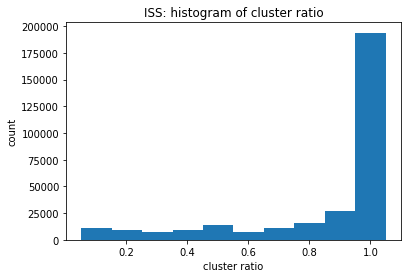

In [20]:
f = plt.hist(iss_ratio['cluster_ratio'], bins=10, align='right')
plt.xlabel('cluster ratio')
plt.ylabel('count')
plt.title('ISS: histogram of cluster ratio')

In [21]:
# evaluate points
iss_decision = eval_points(iss_ratio, cluster='FEAT_SEQ') 

In [22]:
iss_decision['eval'].value_counts(sort=False)

0     21391
1    222425
2     61364
Name: eval, dtype: int64

In [23]:
iss_dropped = drop_points(iss_decision)

In [24]:
print("Number of data points at start:", df_iss.shape[0])
print("Number of data points after dropping:", df_iss.shape[0]-iss_dropped.shape[0])

Number of data points at start: 305180
Number of data points after dropping: 227929


In [25]:
#iss_decision['geometry'] = iss_decision['geometry'].to_crs(epsg=4326)
#iss_decision['x_coor'] = iss_decision['geometry'].x
#iss_decision['y_coor'] = iss_decision['geometry'].y
iss_dropped['geometry'] = iss_dropped['geometry'].to_crs(epsg=4326)
iss_dropped['x_coor'] = iss_dropped['geometry'].x
iss_dropped['y_coor'] = iss_dropped['geometry'].y

In [26]:
iss_decision.head()

,index,starttime,endtime,today,deviceid,date_of_visit,ist,countries,states,districts,wards,designation,name_of_facility_visited,name_of_facility_visited_other,type_of_facility_visited,priority_level,facility_fp_acs,joint_supervision,supervised_by_dsno,supervised_by_who,current_feed_back,surveillance_fp_training,case_def_copy_copy1,facility_fp_acs_copy,physiotherapy_unit,long,lat,F27,F28,F29,F_index,F_parent_table_name,F_parent_index,F_tags,F_notes,F_version,F_duration,F_submitted_by,F_xform_id,Weeknumbers,YearofActiveSurv,OBJECTID,IN_FID,FEAT_SEQ,geometry,date,Country,clean_name,clean_name_final,extract_type,sub_type,type_of_facility_visited_corr,name_of_facility_visited_corr,name_of_facility_visited_type_of_facility_visited,freq_count,match_name,n_subclusters,match_score,match_type,name_seq,type_seq,clusterID,cluster_size,subcluster_size,cluster_ratio,eval
0,0,18/10/2017 11:44:22 am +01:00,18/10/2017 12:07:06 pm +01:00,"Wednesday, 18 October 2017",3.557550e+14,"Wednesday, 18 October 2017",IST_CENTRAL,ANGOLA,BIE,CUNHINGA,PS Hualondo,WHO_STAFF,PS Hualondo,None,CSI,L,Y,Y,1_2_WEEKS,NOT_IN_THE_PAST_1_YEAR,N,MORE_THAN_2_YRS,AFP MEASLES YELLOW_FEVER NNT,NA,N,16.947520,-12.040417,1730.800049,5.0,None,42.0,None,-1.0,None,None,2.017090e+11,1365.0,None,866.0,43.0,2017.0,1,4,1,POINT Z (16.94752 -12.04042 0.00000),2017-10-18,ANGOLA,PS Hualondo,Hualondo,PS,Posto de Saude,CSI,PS Hualondo,PS Hualondo CSI,1,Hualondo,1,NaN,Self,1.0,1.0,100101.0,1,1,1.000000,2
1,1231,22/04/2020 11:10:53 am +01:00,22/04/2020 1:39:44 pm +01:00,"Wednesday, 22 April 2020",3.529140e+14,"Wednesday, 22 April 2020",IST_CENTRAL,ANGOLA,LUNDA NORTE,CHITATO,Hospital Províncial de Chitato,STOP_TEAM,Hospital Províncial de Chitato,None,GENERAL_HOSP,H,Y,N,1_2_WEEKS,1_2_WEEKS,Y,MORE_THAN_2_YRS,NONE,N,N,20.834320,-7.377520,731.600000,4.8,None,2611.0,None,-1.0,None,None,2.019110e+11,8931.0,None,866.0,17.0,2020.0,3,1235,2,POINT Z (20.83432 -7.37752 0.00000),2020-04-22,ANGOLA,Hospital Provincial de Chitato,Chitato,HOSPITAL PROVINCIAL,Hospital,GENERAL_HOSP,Hospital Províncial de Chitato,Hospital Províncial de Chitato GENERAL_HOSP,30,Chitato,4,NaN,Self,1.0,1.0,200101.0,30,1,0.033333,0
27,1,25/10/2017 10:49:30 am +01:00,25/10/2017 10:56:37 am +01:00,"Wednesday, 25 October 2017",3.557550e+14,"Wednesday, 25 October 2017",IST_CENTRAL,ANGOLA,LUNDA NORTE,CHITATO,Distrito do Dundo,REGIONAL_SURVEILLANCE_OFFICER,Hospital Provincial do Dundo,None,GENERAL_HOSP,H,Y,Y,1_2_WEEKS,1_2_WEEKS,N,6_12_MONTHS,AFP MEASLES YELLOW_FEVER NNT,NA,N,20.834097,-7.377393,725.799988,5.0,None,100.0,None,-1.0,None,None,2.017090e+11,428.0,None,866.0,44.0,2017.0,2,5,2,POINT Z (20.83410 -7.37739 0.00000),2017-10-25,ANGOLA,Hospital Provincial do Dundo,Dundo,HOSPITAL PROVINCIAL,Hospital,GENERAL_HOSP,Hospital Provincial do Dundo,Hospital Provincial do Dundo GENERAL_HOSP,30,Dundo,4,NaN,Self,2.0,1.0,200201.0,30,26,0.866667,1
26,13,03/11/2017 11:25:21 am +01:00,03/11/2017 11:36:57 am +01:00,"Friday, 3 November 2017",3.557550e+14,"Friday, 3 November 2017",IST_CENTRAL,ANGOLA,LUNDA NORTE,CHITATO,Distrito do Dundo,REGIONAL_SURVEILLANCE_OFFICER,Hospital Provincial do Dundo,None,GENERAL_HOSP,H,Y,Y,LESS_THAN_1_WEEK,LESS_THAN_1_WEEK,N,6_12_MONTHS,AFP MEASLES YELLOW_FEVER NNT,N,N,20.834159,-7.377371,719.500000,4.5,None,197.0,None,-1.0,None,None,2.017090e+11,696.0,None,866.0,45.0,2017.0,31,17,2,POINT Z (20.83416 -7.37737 0.00000),2017-11-03,ANGOLA,Hospital Provincial do Dundo,Dundo,HOSPITAL PROVINCIAL,Hospital,GENERAL_HOSP,Hospital Provincial do Dundo,Hospital Provincial do Dundo GENERAL_HOSP,30,Dundo,4,100.0,Simple match,2.0,1.0,200201.0,30,26,0.866667,1
25,804,10/11/2017 11:56:58 am +01:00,10/11/2017 12:13:46 pm +01:00,"Friday, 10 November 2017",3.557550e+14,"Friday, 10 November 2017",IST_CENTRAL,ANGOLA,LUNDA NORTE,CHITATO,Distrito do Dundo,REGIONAL_SURVEILLANCE_OFFICER,Hospital Provincial do Dundo,None,GENERAL_HOSP,H,Y,Y,1_2_WEEKS,1_2_WEEKS,N,6_12_MONTHS,AFP MEASLES YELLOW_FEVER NNT,NA,N,20.834214,-7.377442,711.799988,5.0,None,231.

In [27]:
iss_dropped.head()

,index,starttime,endtime,today,deviceid,date_of_visit,ist,countries,states,districts,wards,designation,name_of_facility_visited,name_of_facility_visited_other,type_of_facility_visited,priority_level,facility_fp_acs,joint_supervision,supervised_by_dsno,supervised_by_who,current_feed_back,surveillance_fp_training,case_def_copy_copy1,facility_fp_acs_copy,physiotherapy_unit,long,lat,F27,F28,F29,F_index,F_parent_table_name,F_parent_index,F_tags,F_notes,F_version,F_duration,F_submitted_by,F_xform_id,Weeknumbers,YearofActiveSurv,OBJECTID,IN_FID,FEAT_SEQ,geometry,date,Country,clean_name,clean_name_final,extract_type,sub_type,type_of_facility_visited_corr,name_of_facility_visited_corr,name_of_facility_visited_type_of_facility_visited,freq_count,match_name,n_subclusters,match_score,match_type,name_seq,type_seq,clusterID,cluster_size,subcluster_size,cluster_ratio,eval,x_coor,y_coor
0,0,18/10/2017 11:44:22 am +01:00,18/10/2017 12:07:06 pm +01:00,"Wednesday, 18 October 2017",3.557550e+14,"Wednesday, 18 October 2017",IST_CENTRAL,ANGOLA,BIE,CUNHINGA,PS Hualondo,WHO_STAFF,PS Hualondo,None,CSI,L,Y,Y,1_2_WEEKS,NOT_IN_THE_PAST_1_YEAR,N,MORE_THAN_2_YRS,AFP MEASLES YELLOW_FEVER NNT,NA,N,16.947520,-12.040417,1730.800049,5.0,None,42.0,None,-1.0,None,None,2.017090e+11,1365.0,None,866.0,43.0,2017.0,1,4,1,POINT Z (16.94752 -12.04042 0.00000),2017-10-18,ANGOLA,PS Hualondo,Hualondo,PS,Posto de Saude,CSI,PS Hualondo,PS Hualondo CSI,1,Hualondo,1,NaN,Self,1.0,1.0,100101.0,1,1,1.000000,2,16.947520,-12.040417
2,1048,15/10/2018 11:54:04 am +01:00,15/10/2018 12:00:46 pm +01:00,"Monday, 15 October 2018",3.557550e+14,"Monday, 15 October 2018",IST_CENTRAL,ANGOLA,LUNDA NORTE,CHITATO,Distrito do Dundo,REGIONAL_SURVEILLANCE_OFFICER,Hospital Provincial do Dundo,None,GENERAL_HOSP,H,Y,Y,1_2_WEEKS,1_2_WEEKS,Y,6_12_MONTHS,AFP MEASLES YELLOW_FEVER,N,N,20.834130,-7.377357,729.400024,4.5,None,1571.0,None,-1.0,None,None,2.017090e+11,402.0,None,866.0,42.0,2018.0,6,1052,2,POINT Z (20.83413 -7.37736 0.00000),2018-10-15,ANGOLA,Hospital Provincial do Dundo,Dundo,HOSPITAL PROVINCIAL,Hospital,GENERAL_HOSP,Hospital Provincial do Dundo,Hospital Provincial do Dundo GENERAL_HOSP,30,Dundo,4,100.0,Simple match,2.0,1.0,200201.0,30,26,0.866667,1,20.834130,-7.377357
31,2,24/10/2017 8:13:56 am +01:00,24/10/2017 9:22:26 am +01:00,"Tuesday, 24 October 2017",3.557550e+14,"Monday, 23 October 2017",IST_CENTRAL,ANGOLA,CUNENE,CUROCA,Direção Municipal da Saúde,DISTRICT_HEALTH_FFICER,Comuna de Onconcua,None,DISTRICT_HOSP,Hi,Y,Y,1_MONTH,1_MONTH,Y,6_12_MONTHS,AFP MEASLES YELLOW_FEVER CEREBROSPINAL_MENINGI...,NA,N,13.424907,-16.656308,995.799988,22.0,None,132.0,None,-1.0,None,None,2.017090e+11,4111.0,None,866.0,44.0,2017.0,32,6,3,POINT Z (13.42491 -16.65631 0.00000),2017-10-23,ANGOLA,Comuna de Onconcua,Comuna Onconcua,NaN,NaN,DISTRICT_HOSP,Comuna de Onconcua,Comuna de Onconcua DISTRICT_HOSP,1,Comuna Onconcua,1,NaN,Self,1.0,1.0,300101.0,1,1,1.000000,2,13.424907,-16.656308
36,990,28/06/2018 11:34:55 am +01:00,28/06/2018 11:42:20 am +01:00,"Thursday, 28 June 2018",3.557550e+14,"Thursday, 28 June 2018",IST_CENTRAL,ANGOLA,LUNDA NORTE,CHITATO,Distrito do Dundo,REGIONAL_SURVEILLANCE_OFFICER,Posto Médico Calinhique,None,PRIVATE_FACILITY,L,N,Y,1_2_WEEKS,1_MONTH,N,6_12_MONTHS,AFP MEASLES YELLOW_FEVER NNT,N,N,20.830559,-7.380366,749.799988,5.0,None,1162.0,None,-1.0,None,None,2.017090e+11,445.0,None,866.0,26.0,2018.0,34,994,4,POINT Z (20.83056 -7.38037 0.00000),2018-06-28,ANGOLA,Posto Medico Calinhique,Medico Calinhique,POSTO,Posto de Saude,PRIVATE_FACILITY,Posto Médico Calinhique,Posto Médico Calinhique PRIVATE_FACILITY,5,Medico Calinhique,1,100.0,Simple match,1.0,1.0,400101.0,5,5,1.000000,1,20.830559,-7.380366
37,1055,18/10/2018 10:16:02 am +01:00,18/10/2018 10:21:06 am +01:00,"Thursday, 18 October 2018",3.557550e+14,"Thursday, 18 October 2018",IST_CENTRAL,ANGOLA,LUNDA NORTE,CHITATO,Distrito do Dundo,REGIONAL_SURVEILLANCE_OFFICER,Posto Médico Betesda,None,PRIVATE_FACILITY,M,Y,Y,1_MONTH,1_MONTH,Y,6_12_MONTHS,AFP ME

In [28]:
iss_decision.drop(columns=['OBJECTID', 'IN_FID', 'freq_count'],
                 inplace=True)
iss_decision.rename(columns={'index':'index_original', 'FEAT_SEQ':'Cluster_seq'},
                   inplace=True)
iss_decision.reset_index(drop=True,inplace=True)

In [29]:
iss_dropped.drop(columns=['OBJECTID', 'IN_FID', 'freq_count'],
                 inplace=True)
iss_dropped.rename(columns={'index':'index_original', 'FEAT_SEQ':'Cluster_seq'},
                   inplace=True)
iss_dropped.reset_index(drop=True,inplace=True)

In [30]:
iss_dropped.head()

,index_original,starttime,endtime,today,deviceid,date_of_visit,ist,countries,states,districts,wards,designation,name_of_facility_visited,name_of_facility_visited_other,type_of_facility_visited,priority_level,facility_fp_acs,joint_supervision,supervised_by_dsno,supervised_by_who,current_feed_back,surveillance_fp_training,case_def_copy_copy1,facility_fp_acs_copy,physiotherapy_unit,long,lat,F27,F28,F29,F_index,F_parent_table_name,F_parent_index,F_tags,F_notes,F_version,F_duration,F_submitted_by,F_xform_id,Weeknumbers,YearofActiveSurv,Cluster_seq,geometry,date,Country,clean_name,clean_name_final,extract_type,sub_type,type_of_facility_visited_corr,name_of_facility_visited_corr,name_of_facility_visited_type_of_facility_visited,match_name,n_subclusters,match_score,match_type,name_seq,type_seq,clusterID,cluster_size,subcluster_size,cluster_ratio,eval,x_coor,y_coor
0,0,18/10/2017 11:44:22 am +01:00,18/10/2017 12:07:06 pm +01:00,"Wednesday, 18 October 2017",3.557550e+14,"Wednesday, 18 October 2017",IST_CENTRAL,ANGOLA,BIE,CUNHINGA,PS Hualondo,WHO_STAFF,PS Hualondo,None,CSI,L,Y,Y,1_2_WEEKS,NOT_IN_THE_PAST_1_YEAR,N,MORE_THAN_2_YRS,AFP MEASLES YELLOW_FEVER NNT,NA,N,16.947520,-12.040417,1730.800049,5.0,None,42.0,None,-1.0,None,None,2.017090e+11,1365.0,None,866.0,43.0,2017.0,1,POINT Z (16.94752 -12.04042 0.00000),2017-10-18,ANGOLA,PS Hualondo,Hualondo,PS,Posto de Saude,CSI,PS Hualondo,PS Hualondo CSI,Hualondo,1,NaN,Self,1.0,1.0,100101.0,1,1,1.000000,2,16.947520,-12.040417
1,1048,15/10/2018 11:54:04 am +01:00,15/10/2018 12:00:46 pm +01:00,"Monday, 15 October 2018",3.557550e+14,"Monday, 15 October 2018",IST_CENTRAL,ANGOLA,LUNDA NORTE,CHITATO,Distrito do Dundo,REGIONAL_SURVEILLANCE_OFFICER,Hospital Provincial do Dundo,None,GENERAL_HOSP,H,Y,Y,1_2_WEEKS,1_2_WEEKS,Y,6_12_MONTHS,AFP MEASLES YELLOW_FEVER,N,N,20.834130,-7.377357,729.400024,4.5,None,1571.0,None,-1.0,None,None,2.017090e+11,402.0,None,866.0,42.0,2018.0,2,POINT Z (20.83413 -7.37736 0.00000),2018-10-15,ANGOLA,Hospital Provincial do Dundo,Dundo,HOSPITAL PROVINCIAL,Hospital,GENERAL_HOSP,Hospital Provincial do Dundo,Hospital Provincial do Dundo GENERAL_HOSP,Dundo,4,100.0,Simple match,2.0,1.0,200201.0,30,26,0.866667,1,20.834130,-7.377357
2,2,24/10/2017 8:13:56 am +01:00,24/10/2017 9:22:26 am +01:00,"Tuesday, 24 October 2017",3.557550e+14,"Monday, 23 October 2017",IST_CENTRAL,ANGOLA,CUNENE,CUROCA,Direção Municipal da Saúde,DISTRICT_HEALTH_FFICER,Comuna de Onconcua,None,DISTRICT_HOSP,Hi,Y,Y,1_MONTH,1_MONTH,Y,6_12_MONTHS,AFP MEASLES YELLOW_FEVER CEREBROSPINAL_MENINGI...,NA,N,13.424907,-16.656308,995.799988,22.0,None,132.0,None,-1.0,None,None,2.017090e+11,4111.0,None,866.0,44.0,2017.0,3,POINT Z (13.42491 -16.65631 0.00000),2017-10-23,ANGOLA,Comuna de Onconcua,Comuna Onconcua,NaN,NaN,DISTRICT_HOSP,Comuna de Onconcua,Comuna de Onconcua DISTRICT_HOSP,Comuna Onconcua,1,NaN,Self,1.0,1.0,300101.0,1,1,1.000000,2,13.424907,-16.656308
3,990,28/06/2018 11:34:55 am +01:00,28/06/2018 11:42:20 am +01:00,"Thursday, 28 June 2018",3.557550e+14,"Thursday, 28 June 2018",IST_CENTRAL,ANGOLA,LUNDA NORTE,CHITATO,Distrito do Dundo,REGIONAL_SURVEILLANCE_OFFICER,Posto Médico Calinhique,None,PRIVATE_FACILITY,L,N,Y,1_2_WEEKS,1_MONTH,N,6_12_MONTHS,AFP MEASLES YELLOW_FEVER NNT,N,N,20.830559,-7.380366,749.799988,5.0,None,1162.0,None,-1.0,None,None,2.017090e+11,445.0,None,866.0,26.0,2018.0,4,POINT Z (20.83056 -7.38037 0.00000),2018-06-28,ANGOLA,Posto Medico Calinhique,Medico Calinhique,POSTO,Posto de Saude,PRIVATE_FACILITY,Posto Médico Calinhique,Posto Médico Calinhique PRIVATE_FACILITY,Medico Calinhique,1,100.0,Simple match,1.0,1.0,400101.0,5,5,1.000000,1,20.830559,-7.380366
4,1055,18/10/2018 10:16:02 am +01:00,18/10/2018 10:21:06 am +01:00,"Thursday, 18 October 2018",3.557550e+14,"Thursday, 18 October 2018",IST_CENTRAL,ANGOLA,LUNDA NORTE,CHITATO,Distrito do Dundo,REGIONAL_SURVEILLANCE_OFFICER,Posto Médico Betesda,None,PRIVATE_FACILITY,M,Y,Y,1_MONTH,1_MONTH,Y,6_12_MONTHS,AFP MEASLES YELLOW_FEVER NNT,N,N,20.832738,-7.383519,728

In [31]:
# Export results as csv files
dataDir = r"C:\Users\DUANYUEYUN\Documents\GRID3\Health facilities\Data\Africa"
iss_decision.to_csv(dataDir + "\\Cleaned\\iss_decision1_1028.csv",
                      index=False)
iss_dropped.to_csv(dataDir + "\\Cleaned\\iss_dropped1_1028.csv",
                     index=False)

## Second round cleaning

Starting from here, points with `eval` of 0 in the first phase are dropped and duplicates within subclusters with `eval` of 1 or 2 are also dropped such that there is only one point representing each subcluster.

A new feature sequence is found using a radius of 1km and a match on `match_name`.

In [32]:
# Data import
dataDir = r"C:\Users\DUANYUEYUN\Documents\GRID3\Health facilities\Data\Africa"
iss_dropped1 = pd.read_csv(dataDir + "\\Cleaned\\iss_dropped1_1028.csv")

C:\Users\DUANYUEYUN\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3063: DtypeWarning: Columns (13,20,24,37) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [33]:
iss_dropped1.head()

,index_original,starttime,endtime,today,deviceid,date_of_visit,ist,countries,states,districts,wards,designation,name_of_facility_visited,name_of_facility_visited_other,type_of_facility_visited,priority_level,facility_fp_acs,joint_supervision,supervised_by_dsno,supervised_by_who,current_feed_back,surveillance_fp_training,case_def_copy_copy1,facility_fp_acs_copy,physiotherapy_unit,long,lat,F27,F28,F29,F_index,F_parent_table_name,F_parent_index,F_tags,F_notes,F_version,F_duration,F_submitted_by,F_xform_id,Weeknumbers,YearofActiveSurv,Cluster_seq,geometry,date,Country,clean_name,clean_name_final,extract_type,sub_type,type_of_facility_visited_corr,name_of_facility_visited_corr,name_of_facility_visited_type_of_facility_visited,match_name,n_subclusters,match_score,match_type,name_seq,type_seq,clusterID,cluster_size,subcluster_size,cluster_ratio,eval,x_coor,y_coor
0,0,18/10/2017 11:44:22 am +01:00,18/10/2017 12:07:06 pm +01:00,"Wednesday, 18 October 2017",3.557550e+14,"Wednesday, 18 October 2017",IST_CENTRAL,ANGOLA,BIE,CUNHINGA,PS Hualondo,WHO_STAFF,PS Hualondo,NaN,CSI,L,Y,Y,1_2_WEEKS,NOT_IN_THE_PAST_1_YEAR,N,MORE_THAN_2_YRS,AFP MEASLES YELLOW_FEVER NNT,NaN,N,16.947520,-12.040417,1730.800049,5.0,NaN,42.0,NaN,-1.0,NaN,NaN,2.017090e+11,1365.0,NaN,866.0,43.0,2017.0,1,POINT Z (16.94751950000006 -12.04041699999993 0),2017-10-18,ANGOLA,PS Hualondo,Hualondo,PS,Posto de Saude,CSI,PS Hualondo,PS Hualondo CSI,Hualondo,1,NaN,Self,1.0,1.0,100101.0,1,1,1.000000,2,16.947520,-12.040417
1,1048,15/10/2018 11:54:04 am +01:00,15/10/2018 12:00:46 pm +01:00,"Monday, 15 October 2018",3.557550e+14,"Monday, 15 October 2018",IST_CENTRAL,ANGOLA,LUNDA NORTE,CHITATO,Distrito do Dundo,REGIONAL_SURVEILLANCE_OFFICER,Hospital Provincial do Dundo,NaN,GENERAL_HOSP,H,Y,Y,1_2_WEEKS,1_2_WEEKS,Y,6_12_MONTHS,AFP MEASLES YELLOW_FEVER,N,N,20.834130,-7.377357,729.400024,4.5,NaN,1571.0,NaN,-1.0,NaN,NaN,2.017090e+11,402.0,NaN,866.0,42.0,2018.0,2,POINT Z (20.83413040000005 -7.37735669999995 0),2018-10-15,ANGOLA,Hospital Provincial do Dundo,Dundo,HOSPITAL PROVINCIAL,Hospital,GENERAL_HOSP,Hospital Provincial do Dundo,Hospital Provincial do Dundo GENERAL_HOSP,Dundo,4,100.0,Simple match,2.0,1.0,200201.0,30,26,0.866667,1,20.834130,-7.377357
2,2,24/10/2017 8:13:56 am +01:00,24/10/2017 9:22:26 am +01:00,"Tuesday, 24 October 2017",3.557550e+14,"Monday, 23 October 2017",IST_CENTRAL,ANGOLA,CUNENE,CUROCA,Direção Municipal da Saúde,DISTRICT_HEALTH_FFICER,Comuna de Onconcua,NaN,DISTRICT_HOSP,Hi,Y,Y,1_MONTH,1_MONTH,Y,6_12_MONTHS,AFP MEASLES YELLOW_FEVER CEREBROSPINAL_MENINGI...,NaN,N,13.424907,-16.656308,995.799988,22.0,NaN,132.0,NaN,-1.0,NaN,NaN,2.017090e+11,4111.0,NaN,866.0,44.0,2017.0,3,POINT Z (13.42490670000007 -16.65630839999994 0),2017-10-23,ANGOLA,Comuna de Onconcua,Comuna Onconcua,NaN,NaN,DISTRICT_HOSP,Comuna de Onconcua,Comuna de Onconcua DISTRICT_HOSP,Comuna Onconcua,1,NaN,Self,1.0,1.0,300101.0,1,1,1.000000,2,13.424907,-16.656308
3,990,28/06/2018 11:34:55 am +01:00,28/06/2018 11:42:20 am +01:00,"Thursday, 28 June 2018",3.557550e+14,"Thursday, 28 June 2018",IST_CENTRAL,ANGOLA,LUNDA NORTE,CHITATO,Distrito do Dundo,REGIONAL_SURVEILLANCE_OFFICER,Posto Médico Calinhique,NaN,PRIVATE_FACILITY,L,N,Y,1_2_WEEKS,1_MONTH,N,6_12_MONTHS,AFP MEASLES YELLOW_FEVER NNT,N,N,20.830559,-7.380366,749.799988,5.0,NaN,1162.0,NaN,-1.0,NaN,NaN,2.017090e+11,445.0,NaN,866.0,26.0,2018.0,4,POINT Z (20.83055870000004 -7.38036569999997 0),2018-06-28,ANGOLA,Posto Medico Calinhique,Medico Calinhique,POSTO,Posto de Saude,PRIVATE_FACILITY,Posto Médico Calinhique,Posto Médico Calinhique PRIVATE_FACILITY,Medico Calinhique,1,100.0,Simple match,1.0,1.0,400101.0,5,5,1.000000,1,20.830559,-7.380366
4,1055,18/10/2018 10:16:02 am +01:00,18/10/2018 10:21:06 am +01:00,"Thursday, 18 October 2018",3.557550e+14,"Thursday, 18 October 2018",IST_CENTRAL,ANGOLA,LUNDA NORTE,CHITATO,Distrito do Dundo,REGIONAL_SURVEILLANCE_OFFICER,Posto Médico Betesda,NaN,PRIVATE_FACILITY,M,Y,Y,1_MONTH,1_MONTH,Y,6_12_MONTHS,AFP MEASLES YELLOW_FEVER NNT,N,

In [34]:
dataDir2 = r"C:\Users\DUANYUEYUN\Documents\ArcGIS\Projects\WHO_ISS"
feat_seq = gpd.read_file(dataDir2+"\\WHO_ISS.gdb", driver='FileGDB', 
                       layer= 'iss_dropped1_1028_FI')

In [35]:
feat_seq.shape

(77789, 3)

In [36]:
feat_seq = feat_seq.sort_values(by=['IN_FID', 'FEAT_SEQ'])\
.drop_duplicates(subset='IN_FID', keep='first')
feat_seq['IN_FID'] = feat_seq['IN_FID']-1
# add feature sequence to original dataset
iss_dropped1 = iss_dropped1.merge(feat_seq.drop(columns=['geometry']), left_index=True, right_on='IN_FID')

In [39]:
#iss_dropped1[iss_dropped1['FEAT_SEQ']==12]

In [40]:
print("Number of data points:", iss_dropped1.shape[0])
print("Number of clusters:", iss_dropped1['FEAT_SEQ'].max())

Number of data points: 77251
Number of clusters: 65547


In [41]:
def eval_phase2(df, cluster='FEAT_SEQ', decision='eval',
               subcluster_size='subcluster_size', new_decision = 'eval2'):
    
    """Evaluate points within the new cluster.
    0 means drop and 1 means keep.
    decision: column name for first phase evaluation.
    new_decision: column name for second phase evaluation."""
    
    drop = []
    df.sort_values([cluster, decision, subcluster_size], inplace=True)
    df_grouped = df.groupby(cluster)
    
    for name, df_group in df_grouped:
        max_subcluster = df_group[subcluster_size].max()
        
        # There are points with both eval=1 and eval=2 in the cluster
        if df_group[decision].nunique()>1:
            # If there are more than 1 point with eval=1, keep the point with max sublcuster size
            if df_group[df_group[decision]==1].shape[0]>1:
                for idx, row in df_group.iterrows():
                    # Keep only points with eval=1
                    if row[decision]==1 and row[subcluster_size]==max_subcluster:
                        drop.append(1)
                    # Drop points with eval=2  
                    else:
                        drop.append(0)
            # There is only 1 point with eval=1, just keep that point and drop the rest
            else:
                for idx, row in df_group.iterrows():
                    # Keep only points with eval=1
                    if row[decision]==1:
                        drop.append(1)
                    # Drop points with eval=2  
                    else:
                        drop.append(0)
        # There are either points with eval=1 or points with eval=2 (exclusive)       
        else:
            for idx, row in df_group.iterrows():
                # Keep only points with the maximum subcluster size
                if row[subcluster_size]==max_subcluster:
                    drop.append(1)
                # Drop all other points   
                else:
                    drop.append(0)
                 
    df[new_decision] = drop
    return df                         

In [42]:
iss_decision2 = eval_phase2(iss_dropped1)

In [43]:
iss_decision2['eval2'].value_counts()

1    68483
0     8768
Name: eval2, dtype: int64

In [44]:
# drop points with eval=0 in second phase cleaning
iss_dropped2 = iss_decision2[iss_decision2['eval2']==1]

In [46]:
iss_decision2.drop(columns=['IN_FID'], inplace=True)
iss_decision2.rename(columns={'FEAT_SEQ':'Cluster_seq2'}, inplace=True)
iss_decision2.reset_index(drop=True, inplace=True)

In [48]:
iss_dropped2.drop(columns=['IN_FID'], inplace=True)
iss_dropped2.rename(columns={'FEAT_SEQ':'Cluster_seq2'}, inplace=True)
iss_dropped.reset_index(drop=True, inplace=True)

In [50]:
iss_decision2.to_csv(dataDir+"\\Cleaned\\iss_decision2_1028.csv",
                   index=False)
iss_dropped2.to_csv(dataDir+"\\Cleaned\\iss_dropped2_1028.csv",
                   index=False)